# NLP Tweets for Natural Disasters
#### Github link: https://github.com/wiwi9262/tweet_distasters
## Overview
* We have a large corpus of tweets
* We would like to know which of these tweets are related to natural disasters
* There are thousands of unique words that we need to look at as part of our analysis
* We plan to use term frequency inverse document frequency to build our initial features
* This method is not perfect, but it provides more than a simple bag of words approach

In [46]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
#import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import nltk
from nltk.corpus import stopwords
#from nltk.classify import SklearnClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

## Data Download and Cleaning

In [16]:
# We need the stopwords lists so we can remove extremely common words that will not help our analysis
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
dfTweets = pd.read_csv("../input/nlp-getting-started/train.csv")
dfTweetsTest = pd.read_csv("../input/nlp-getting-started/test.csv")

In [18]:
# We see a lot of NaN in keyword and locatin
# We will explore further but it is likely that we will not be able to use these
dfTweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
dfTweetsTest.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [20]:
dfTweets.info()
# We can see that there are more than 2000 null locations and about 60 null keywords
# Probably too many null locations to be useful, unless the ones that are there are really impactful

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [21]:
dfTweetsTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [22]:
dfTweets['keyword'].value_counts()
# There are 221 unique keywords

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [23]:
dfTweets['location'].value_counts()
# This is a mess. Just drop it

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

In [24]:
# Remove URLs
dfTweets['text'] = dfTweets['text'].replace(r'http\S+', '', regex=True)

# Make this simple and remove any character that is not in range of English letters
# There are emoji and punctuation that we cant reasonably use. just clear it all out
dfTweets['text'] = dfTweets['text'].replace(r'[^A-Za-z]', ' ', regex=True)
dfTweets['text']

0       Our Deeds are the Reason of this  earthquake M...
1                  Forest fire near La Ronge Sask  Canada
2       All residents asked to  shelter in place  are ...
3              people receive  wildfires evacuation or...
4       Just got sent this photo from Ruby  Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609     aria ahrary  TheTawniest The out of control w...
7610          M            UTC   km S of Volcano Hawaii  
7611    Police investigating after an e bike collided ...
7612    The Latest  More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [25]:
# Drop Duplicates
# There are a lot of records that have duplicate text
# I am dropping the duplicates so they dont lead to overtraining issues
dfTweets.drop_duplicates(subset=['text'], inplace=True)
dfTweets.reset_index(inplace=True)
dfTweets['text']

0       Our Deeds are the Reason of this  earthquake M...
1                  Forest fire near La Ronge Sask  Canada
2       All residents asked to  shelter in place  are ...
3              people receive  wildfires evacuation or...
4       Just got sent this photo from Ruby  Alaska as ...
                              ...                        
6957    a siren just went off and it wasn t the Forney...
6958    Officials say a quarantine is in place at an A...
6959     WorldNews Fallen powerlines on G link tram  U...
6960    on the flip side I m at Walmart and there is a...
6961    Suicide bomber kills    in Saudi security site...
Name: text, Length: 6962, dtype: object

### Exploratory Data Analysis
* There are a lot of unique words so we will limit what we will illustrate
* We explore the data as we extract features
* Additional Visualizations are included after feature extraction

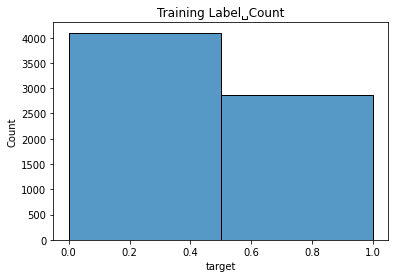

In [26]:
sns.histplot(data=dfTweets, x="target",bins=2).set(title='Training Label␣Count');

### Feature Extraction

In [27]:
# Feature Extraction
# We will use TD-IDF

# https://www.kaggle.com/code/amar09/nltk-feature-extraction-and-sentiment-analysis/notebook
stopwords_set = set(stopwords.words("english"))
vectorizer = TfidfVectorizer(stop_words=stopwords_set)
trans = vectorizer.fit_transform(dfTweets['text'])
vectorizer.get_feature_names_out()

# Some of these are clearly the same word but I am not going to word stem it. 


array(['aa', 'aaaa', 'aaaaaaallll', ..., 'zurich', 'zxathetis', 'zzzz'],
      dtype=object)

In [28]:
trans.shape

(6962, 16050)

In [29]:
dfSparse = pd.DataFrame(pd.DataFrame.sparse.from_spmatrix(trans))

In [30]:
# Look at top n words 
# Could not run this due to memory constraints
# The plan was to get the top features(words) then create visualizations showing proportion of those words 
#     for each label
### Unfortunately, the code gave error that it couldn't allocate the memory required
"""
feature_array = np.array(vectorizer.get_feature_names())
tfidf_sorting = np.argsort(trans.toarray()).flatten()[::-1]
n = 5
top_n = feature_array[tfidf_sorting][:n]
"""



'\nfeature_array = np.array(vectorizer.get_feature_names())\ntfidf_sorting = np.argsort(trans.toarray()).flatten()[::-1]\nn = 5\ntop_n = feature_array[tfidf_sorting][:n]\n'

### Train the models

#### Model 1
* We originally created a RNN for the first model
* It was taking way to long to train
* When we attempted a basic back propagation neural network, we saw that it had good results out of the box 

In [31]:
x_train,  x_test, y_train, y_test = train_test_split(dfSparse,dfTweets['target'],test_size = 0.2)


In [32]:
shape = x_test.shape[1]

In [33]:
model1 = models.Sequential()
model1.add(layers.Dense(32, activation="relu"))
model1.add(layers.Dense(1, activation="sigmoid")) 
model1.compile(optimizer='adam',
               loss="binary_crossentropy",
               metrics=['accuracy'])

2022-05-31 18:31:39.972789: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [34]:
model1.build(input_shape=(None,shape))
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                513632    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 513,665
Trainable params: 513,665
Non-trainable params: 0
_________________________________________________________________


In [37]:
batch_size = 32
es = EarlyStopping(monitor='val_loss', mode='auto', patience=2, verbose=1)
model1.fit(
    x_train, y_train, validation_data=(x_test, y_test), 
    batch_size=batch_size, epochs=20,
    callbacks=[es]
)
# Got memory error and had to change memory of VM to run this

Epoch 1/20
175/175 [==============================] - 1s 8ms/step - loss: 0.0470 - accuracy: 0.9896 - val_loss: 0.5661 - val_accuracy: 0.7645
Epoch 2/20
175/175 [==============================] - 1s 4ms/step - loss: 0.0384 - accuracy: 0.9914 - val_loss: 0.5846 - val_accuracy: 0.7717
Epoch 3/20
175/175 [==============================] - 1s 4ms/step - loss: 0.0324 - accuracy: 0.9930 - val_loss: 0.6107 - val_accuracy: 0.7609
Epoch 00003: early stopping


In [38]:
# Test It

# Make this stuff into a function
# Remove URLs
dfTweetsTest['text'] = dfTweetsTest['text'].replace(r'http\S+', '', regex=True)
# Make this simple and remove any character that is not in range of English letters
dfTweetsTest['text'] = dfTweetsTest['text'].replace(r'[^A-Za-z]', ' ', regex=True)
trans_test = vectorizer.transform(dfTweetsTest['text'])


In [39]:
dfSparseTest = pd.DataFrame(pd.DataFrame.sparse.from_spmatrix(trans_test))

In [40]:
y_pred = model1.predict(dfSparseTest)

In [41]:
y_pred.shape

(3263, 1)

In [42]:
index_reset = dfTweetsTest['id'].reset_index()

In [43]:
index_reset['target'] = y_pred.round().astype(int)

In [44]:
index_reset = index_reset.drop('index',axis=1)

In [45]:
index_reset.to_csv("test_data.csv",index=False)

#### Model 2
* There are a lot of features and things are sparse
* We want to see if PCA will work to improve performance

In [72]:
# Start with dfSparse and PCA it
dfScaled = StandardScaler().fit_transform(dfSparse.sparse.to_dense())

In [73]:
pca = PCA(n_components=0.95)

In [74]:
pricipalComponents = pca.fit_transform(dfScaled)

In [75]:
dfPCA = pd.DataFrame(data = pricipalComponents)

In [76]:
dfPCA
# PCA did not reduce the number of feature by as much as I was hoping with an explained variance setting of 95%
# We got reduce to about a third but I was hoping for more

,0,1,2,3,4,5,6,7,8,9,...,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083
0,-0.078239,-0.059097,-0.088612,-0.064248,-0.077703,-0.071834,-0.091831,-0.105413,-0.030995,0.209931,...,3.573027,3.527792,-2.674477,-1.939103,-0.154365,-4.237834,5.724807,-2.733402,0.637556,4.372344
1,-0.087677,-0.097656,-0.107262,-0.053224,-0.068927,-0.064815,-0.108207,-0.094312,0.011191,-0.082191,...,0.122445,0.217479,-0.397394,0.016972,-0.301586,0.213998,-0.019760,-0.088871,-0.143952,-0.031781
2,-0.097218,-0.117339,-0.110340,-0.077047,-0.075919,-0.083193,-0.141215,-0.127405,-0.050976,-0.023662,...,1.950131,1.558722,-1.188495,-1.192894,-0.664467,-1.828405,0.771438,-0.950145,0.831304,-0.841750
3,-0.074988,-0.110750,-0.113140,-0.042910,-0.070116,-0.000215,-0.091503,-0.106347,-0.023609,-0.094358,...,-0.266367,-0.261358,-0.327892,-0.746833,-0.015095,0.221197,-0.493712,-0.260344,0.641124,-0.353278
4,-0.085266,-0.114545,-0.115498,-0.060910,-0.077873,-0.023808,-0.089835,-0.075962,-0.038396,-0.088510,...,0.197062,0.391773,-0.187452,0.578017,0.528905,0.216513,-0.362800,-0.195314,0.026133,-0.544563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6957,-0.079908,-0.119963,-0.103486,-0.056947,-0.063933,-0.072289,0.008172,0.893871,-0.522908,0.069312,...,-1.239300,0.099060,-3.516804,-3.841305,-4.814662,3.082075,-3.621484,-3.364453,-3.086844,1.070920
6958,-0.116479,-0.129516,-0.146840,-0.091773,-0.080399,-0.114345,-0.122161,-0.133403,-0.038602,-0.027939,...,0.106050,0.056327,0.210149,0.011611,0.117060,0.161468,-0.046727,-0.080902,0.143639,0.171874
6959,-0.120347,-0.149664,-0.157010,-0.095254,-0.101343,0.014169,-0.130838,-0.109889,-0.009812,-0.025372,...,-0.025185,-0.234559,-0.575541,-0.175855,-0.020906,0.110054,-0.416302,0.015159,-0.716243,-0.012042
6960,-0.046046,-0.106149,0.008219,-0.061119,-0.078789,-0.051406,0.830471,-0.054644,-0.000386,-0.067867,...,-0.383817,-2.121286,0.427881,1.077513,-0.598742,-1.132784,0.579136,-1.010110,0.758766,0.114784


In [77]:
x_train,  x_test, y_train, y_test = train_test_split(dfPCA,dfTweets['target'],test_size = 0.2)

In [78]:
model2 = models.Sequential()
model2.add(layers.Dense(32, activation="relu"))
model2.add(layers.Dense(1, activation="sigmoid")) 
model2.compile(optimizer='adam',
               loss="binary_crossentropy",
               metrics=['accuracy'])


In [79]:
shape = x_test.shape[1]
model2.build(input_shape=(None,shape))
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                162720    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 162,753
Trainable params: 162,753
Non-trainable params: 0
_________________________________________________________________


In [80]:
batch_size = 32
es = EarlyStopping(monitor='val_loss', mode='auto', patience=2, verbose=1)
model2.fit(
    x_train, y_train, validation_data=(x_test, y_test), 
    batch_size=batch_size, epochs=20,
    callbacks=[es]
)

Epoch 1/20
175/175 [==============================] - 1s 4ms/step - loss: 0.8981 - accuracy: 0.6190 - val_loss: 0.8113 - val_accuracy: 0.6834
Epoch 2/20
175/175 [==============================] - 1s 3ms/step - loss: 0.1083 - accuracy: 0.9646 - val_loss: 0.8298 - val_accuracy: 0.6834
Epoch 3/20
175/175 [==============================] - 1s 3ms/step - loss: 0.0749 - accuracy: 0.9776 - val_loss: 0.8563 - val_accuracy: 0.6906
Epoch 00003: early stopping


In [ ]:
# The validation accuracy was not good. It seems that this overtrains too quickly

#### Model 3
* The previous model showed poor results because it quickly overtrained
* We will add a dropout layer

In [81]:
model3 = models.Sequential()
model3.add(layers.Dense(32, activation="relu"))
model3.add(layers.Dropout(0.2, (None, 32)))
model3.add(layers.Dense(1, activation="sigmoid")) 
model3.compile(optimizer='adam',
               loss="binary_crossentropy",
               metrics=['accuracy'])
model3.build(input_shape=(None, shape))
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                162720    
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 162,753
Trainable params: 162,753
Non-trainable params: 0
_________________________________________________________________


In [82]:
model3.fit(
    x_train, y_train, validation_data=(x_test, y_test), 
    batch_size=batch_size, epochs=20,
    callbacks=[es]
)

Epoch 1/20
175/175 [==============================] - 1s 4ms/step - loss: 0.9796 - accuracy: 0.6466 - val_loss: 0.7686 - val_accuracy: 0.6906
Epoch 2/20
175/175 [==============================] - 1s 3ms/step - loss: 0.1612 - accuracy: 0.9461 - val_loss: 0.7867 - val_accuracy: 0.7164
Epoch 3/20
175/175 [==============================] - 1s 3ms/step - loss: 0.1020 - accuracy: 0.9671 - val_loss: 0.8230 - val_accuracy: 0.7164
Epoch 00003: early stopping


In [89]:
# This isnt bad, but lets try to add a LSTM layer

#### Model 4
* Adding a LSTM layer to model 3

In [116]:
x_train.shape

(5569, 5084)

In [117]:
x_test.shape

(1393, 5084)

In [126]:
# Need to reshape before I can use LSTM
n_features = x_train.shape[1]
train_rows = x_train.shape[0]
test_rows = x_test.shape[0]
x_train_array = x_train.to_numpy().reshape(train_rows, n_features, 1)
x_test_array = x_test.to_numpy().reshape(test_rows, n_features, 1)

In [137]:
model4 = models.Sequential()
model4.add(layers.Input(shape=(n_features,1)))
model4.add(layers.Bidirectional(layers.LSTM(units=32)))
model4.add(layers.Dense(32, activation="relu"))
model4.add(layers.Dropout(0.2, (None, 32)))
model4.add(layers.Dense(1, activation="sigmoid")) 
model4.compile(optimizer='adam',
               loss="binary_crossentropy",
               metrics=['accuracy'])


In [138]:
model4.fit(
    [x_train_array], y_train, validation_data=([x_test_array],y_test),
    batch_size=batch_size, epochs=20,
    callbacks=[es]
)

Epoch 1/20
175/175 [==============================] - 1224s 7s/step - loss: 0.6803 - accuracy: 0.5795 - val_loss: 0.6757 - val_accuracy: 0.5908
Epoch 2/20
175/175 [==============================] - 1227s 7s/step - loss: 0.6771 - accuracy: 0.5850 - val_loss: 0.6749 - val_accuracy: 0.6009
Epoch 3/20
175/175 [==============================] - 1191s 7s/step - loss: 0.6795 - accuracy: 0.5820 - val_loss: 0.6748 - val_accuracy: 0.5994
Epoch 4/20
175/175 [==============================] - 1150s 7s/step - loss: 0.6808 - accuracy: 0.5827 - val_loss: 0.6778 - val_accuracy: 0.6016
Epoch 5/20
175/175 [==============================] - 1131s 6s/step - loss: 0.6793 - accuracy: 0.5845 - val_loss: 0.6737 - val_accuracy: 0.6001
Epoch 6/20
175/175 [==============================] - 1148s 7s/step - loss: 0.6786 - accuracy: 0.5861 - val_loss: 0.6748 - val_accuracy: 0.6016
Epoch 7/20
175/175 [==============================] - 1202s 7s/step - loss: 0.6777 - accuracy: 0.5861 - val_loss: 0.6736 - val_accuracy:

In [ ]:
# Not good 

#### Model 5
* Go back to original data and see if we can train it using bidirectional LSTM without crashing everything

In [140]:
# Need to split again since we are going back to pre-PCA data
x_train,  x_test, y_train, y_test = train_test_split(dfSparse,dfTweets['target'],test_size = 0.2)
# Reshape to fit the model
n_features = x_train.shape[1]
train_rows = x_train.shape[0]
test_rows = x_test.shape[0]
x_train_array = x_train.to_numpy().reshape(train_rows, n_features, 1)
x_test_array = x_test.to_numpy().reshape(test_rows, n_features, 1)

In [141]:
model5 = models.Sequential()
model5.add(layers.Input(shape=(n_features,1)))
model5.add(layers.Bidirectional(layers.LSTM(units=32)))
model5.add(layers.Dense(32, activation="relu"))
model5.add(layers.Dropout(0.2, (None, 32)))
model5.add(layers.Dense(1, activation="sigmoid")) 
model5.compile(optimizer='adam',
               loss="binary_crossentropy",
               metrics=['accuracy'])

In [143]:
es = EarlyStopping(monitor='val_loss', mode='auto', patience=4, verbose=1)
# Giving this one more patience to see if it breaks out of rut on early train
# Hopefully it doesnt need all 40 epochs
# ETA for epoch 1 started at 1:20, so I will check on this tomorrow
model5.fit(
    [x_train_array], y_train, validation_data=([x_test_array],y_test),
    batch_size=batch_size, epochs=40,
    callbacks=[es]
)


Epoch 1/40
175/175 [==============================] - 4624s 26s/step - loss: 0.6797 - accuracy: 0.5886 - val_loss: 0.6780 - val_accuracy: 0.5894
Epoch 2/40
175/175 [==============================] - 4503s 26s/step - loss: 0.6788 - accuracy: 0.5886 - val_loss: 0.6771 - val_accuracy: 0.5894
Epoch 3/40
175/175 [==============================] - 4531s 26s/step - loss: 0.6788 - accuracy: 0.5886 - val_loss: 0.6771 - val_accuracy: 0.5894
Epoch 4/40
175/175 [==============================] - 4485s 26s/step - loss: 0.6779 - accuracy: 0.5886 - val_loss: 0.6780 - val_accuracy: 0.5894
Epoch 5/40
175/175 [==============================] - 4517s 26s/step - loss: 0.6786 - accuracy: 0.5886 - val_loss: 0.6771 - val_accuracy: 0.5894
Epoch 6/40
175/175 [==============================] - 4514s 26s/step - loss: 0.6782 - accuracy: 0.5886 - val_loss: 0.6771 - val_accuracy: 0.5894
Epoch 7/40
175/175 [==============================] - 4495s 26s/step - loss: 0.6781 - accuracy: 0.5886 - val_loss: 0.6771 - val_ac

### Analysis of Results

* The first successful model we tested was a shallow backpropagation network. 
* It had validation results around 70%
* Our next attempt with a more robust network overtrained
* It had good accuracy with training data but had poor validation
* We added a dropout layer and tried PCA to fix some issues
* That helped some but the simple model was still competative with this more complex model
* Considering the difference in training time, the extra complexity was not worth it

| Model | Training Accuracy | Validation Accuracy |
|-|-|-|
| 1 | 0.9930 | 0.7609 | 
| 2 | 0.9776 | 0.6906 | 
| 3 | 0.9672 | 0.7164 |
| 4 | 0.5881 | 0.6016 |
| 5 | 0.5886 | 0.5894 |

* Model 4 may have continued to improve but it met the early stop threshold after 10 epochs
* It was improving very slowly


### References
* https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275
* https://towardsdatascience.com/how-to-turn-text-into-features-478b57632e99